In [92]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import defaultdict
%matplotlib inline

In [106]:
test2 = pd.read_csv("helper/test.csv")
train = pd.read_csv("helper/train.csv")
artists = pd.read_csv("helper/artists.csv")
profiles = pd.read_csv("helper/profiles.csv")

median_age = profiles.age.median()
profiles.age = [median_age if (age > 110) or (age < 0) else age for age in profiles.age]

In [70]:
artistdf = pd.read_pickle('helper/artist_df.pkl')
artistdf = artistdf.rename(columns={'artist_id' : 'artist'})
artistdf.shape

(2000, 201)

In [56]:
n_user_plays = {}
for user in train.groupby('user') :
    n_user_plays[user[0]] = len(user[1])

In [57]:
%time
user_medians = {}
for user in train.groupby('user') :
    user_medians[user[0]] = user[1]['plays'].median()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [58]:
GLOBAL_USER_MEDIAN = np.median(user_medians.values())
print GLOBAL_USER_MEDIAN

106.0


In [59]:
%time
artist_medians = {}
for artist in train.groupby('artist') :
    artist_medians[artist[0]] = artist[1]['plays'].median()

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.11 µs


In [60]:
GLOBAL_ARTIST_MEDIAN = np.median(artist_medians.values())
print GLOBAL_ARTIST_MEDIAN 

113.0


In [61]:
def add_medians(traindf, testdf, GLOBAL_USER_MEDIAN, GLOBAL_ARTIST_MEDIAN) :
    user_medians = defaultdict(lambda: GLOBAL_USER_MEDIAN)
    artist_medians = defaultdict(lambda: GLOBAL_ARTIST_MEDIAN)

    ldfu=traindf.groupby('user')
    ldfa=traindf.groupby('artist')

    for u in ldfu :
        user_medians[u[0]] = u[1]['plays'].median()
    for a in ldfa : 
        artist_medians[a[0]] = a[1]['plays'].median()

    testdf['user_median'] = [user_medians[user] for user in testdf['user']]
    testdf['artist_median'] = [artist_medians[artist] for artist in testdf['artist']]
    
    return testdf

In [4]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user')
    ldfa=ldf.groupby('artist')
    user_median=ldfu.plays.median()
    user_artist_count=ldfu.artist.count()
    artist_median=ldfa.plays.median()
    artist_user_count=ldfa.user.count()
    
    nldf=ldf.copy()
    nldf.set_index(['artist'], inplace=True)
    nldf['artist_median']=artist_median
    nldf['artist_user_count']=artist_user_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user'], inplace=True)
    nldf['user_median']=user_median
    nldf['user_artist_count']=user_artist_count
    nldf.reset_index(inplace=True)
    return nldf

In [62]:
def Randomizing(df):
    touse = df.copy()
    df2 = touse.reindex(np.random.permutation(df.index))
    return(df2)
df_randomized = Randomizing(train)

In [112]:
train = df_randomized
test = test2.copy()

In [113]:
artistdf = pd.read_pickle('helper/artist_df.pkl')
artistdf = artistdf.rename(columns={'artist_id' : 'artist'})
artistdf.shape

big_train=recompute_frame(train)
big_train.drop(['artist_user_count','user_artist_count'],axis=1,inplace=True)
merged = pd.merge(big_train, profiles, on="user")
merged['is_male'] = pd.get_dummies(merged['sex'])['m']
merged.drop(['sex'],axis=1,inplace=True)

country_list = defaultdict(int)
for country in profiles['country'] :
    country_list[country] += 1
    
for country in country_list.keys() :
    if country_list[country] > 2000 :
        merged[str(country)] = [1 if country == someCountry else 0 for someCountry in merged['country']]
        
artistdf.drop(['std','name','median','mean','is_male','is_indiv'],axis=1,inplace=True)
artistdf.drop([col for col in artistdf.columns if 'begin_' in col],axis=1,inplace=True)
artistdf.drop([col for col in artistdf.columns if 'label_' in col],axis=1,inplace=True)
#artistdf.drop([col for col in artistdf.columns if 'area_' in col],axis=1,inplace=True)

sample = pd.merge(merged, artistdf, on="artist")

In [114]:
y_train = sample['plays']
x_train = sample.drop(['user','artist','plays','country'],axis=1).fillna(0)

In [115]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [116]:
artistdf = pd.read_pickle('helper/artist_df.pkl')
artistdf = artistdf.rename(columns={'artist_id' : 'artist'})
artistdf.shape

big_test=add_medians(train, test, GLOBAL_USER_MEDIAN, GLOBAL_ARTIST_MEDIAN)
#big_test.drop(['artist_user_count','user_artist_count'],axis=1,inplace=True)
merged = pd.merge(big_test, profiles, on="user")
merged['is_male'] = pd.get_dummies(merged['sex'])['m']
merged.drop(['sex'],axis=1,inplace=True)

country_list = defaultdict(int)
for country in profiles['country'] :
    country_list[country] += 1
    
for country in country_list.keys() :
    if country_list[country] > 2000 :
        merged[str(country)] = [1 if country == someCountry else 0 for someCountry in merged['country']]

artistdf.drop(['std','name','median','mean','is_male','is_indiv'],axis=1,inplace=True)
artistdf.drop([col for col in artistdf.columns if 'begin_' in col],axis=1,inplace=True)
artistdf.drop([col for col in artistdf.columns if 'label_' in col],axis=1,inplace=True)
#artistdf.drop([col for col in artistdf.columns if 'area_' in col],axis=1,inplace=True)

sample = pd.merge(merged, artistdf, on="artist")

In [117]:
#y_test = sample['plays']
x_test = sample.drop(['user','artist','country'],axis=1).fillna(0)

In [118]:
y_pred = LR.predict(x_test)

In [103]:
def MAE(arr1, arr2) :
    if len(arr1) == len(arr2) :
        plt.hist(np.abs(arr1-arr2));
        print 1.0/len(arr1) * np.sum(np.abs(arr1 - arr2))
    else :
        print "Array not the same length"

193.229654917


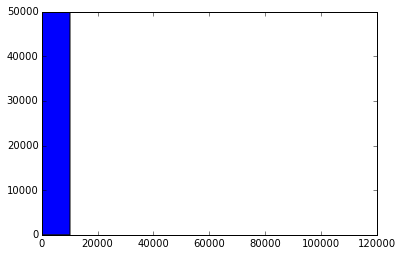

In [104]:
MAE(y_pred,y_test)

In [123]:
toExport = pd.DataFrame()
toExport['Id'] = ids
toExport['plays'] = y_pred
toExport.to_csv('upload.csv',index=False)

In [110]:
ids = test2['Id']
test2.drop('Id',axis=1,inplace=True)

In [121]:
toExport.head()

,Id,pred
0,1,179.198856
1,2,657.537480
2,3,198.310617
3,4,153.721453
4,5,221.199193


In [125]:
user_median = pd.read_csv("user_median.csv")

In [126]:
user_median[0:10]

,Id,plays
0,1,72.5
1,2,143.5
2,3,207.0
3,4,307.0
4,5,109.0
5,6,124.0
6,7,336.0
7,8,118.0
8,9,443.5
9,10,148.0


In [129]:
test.head()

,user,artist,user_median,artist_median
0,306e19cce2522fa2d39ff5dfc870992100ec22d2,4ac4e32b-bd18-402e-adad-ae00e72f8d85,72.5,176.0
1,9450d351278df4938bdea4ed86aec940a4e927ac,1f574ab1-a46d-4586-9331-f0ded23e0411,143.5,111.0
2,801909d6955f59033c88595d3d7f8a6a5dcd53cc,3eb72791-6322-466b-87d3-24d74901eb2d,207.0,138.5
3,e3ed47445c127fbeff47fb58f6bbf2f3b4535d82,61604b45-8a91-4e33-a1b6-45d7b1fec4e5,307.0,169.5
4,a73f46652103f3a5f7429159310f6928f79644aa,5dfdca28-9ddc-4853-933c-8bc97d87beec,109.0,135.0


In [135]:
for col in sample.columns :
    print col

user
artist
user_median
artist_median
age
country
is_male
Canada
Russian Federation
Spain
Netherlands
Finland
Turkey
Czech Republic
France
Norway
United States
Sweden
Austria
Brazil
Australia
Belgium
Switzerland
Portugal
Italy
Germany
Poland
Mexico
United Kingdom
started
tw_followers
youtube_subs
n_single
ntweets
popularity
n_live
n_album
n_ep
sp_followers
n_unspecified_type
n_other
genre_newwave
genre_rockandindie
genre_folk
genre_canadian
genre_usa
genre_indiepop
genre_folkrock
genre_indie
genre_dance-pop
genre_hip-hop
genre_progressiverock
genre_danceandelectronica
genre_rock
genre_european
genre_electronica
genre_poprock
genre_punk
genre_british
genre_american
genre_punkrock
genre_electronic
genre_powermetal
genre_popandchart
genre_hiphop
genre_electropop
genre_german
genre_jazz
genre_bluesrock
genre_heavymetal
genre_pop
genre_alternativerock
genre_deathmetal
genre_hardrock
genre_ambient
genre_classicpopandrock
genre_english
genre_alternative
genre_américain
genre_classical
genre_d